In [2]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.PASCAL_2007)

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [7]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [9]:
dblock = DataBlock()

In [10]:
dsets = dblock.datasets(df)

In [11]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [12]:
x, y = dsets.train[0]
x, y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [16]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

In [18]:
dsets.train[0]

('005624.jpg', 'bird')

In [19]:
def get_x(r):
    return path/'train'/r['fname']
def get_y(r):
    return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/rainf/.fastai/data/pascal_2007/train/006932.jpg'), ['person'])

In [24]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y
)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x288,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [25]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [28]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(128, min_scale=0.35),
)
dls = dblock.dataloaders(df)

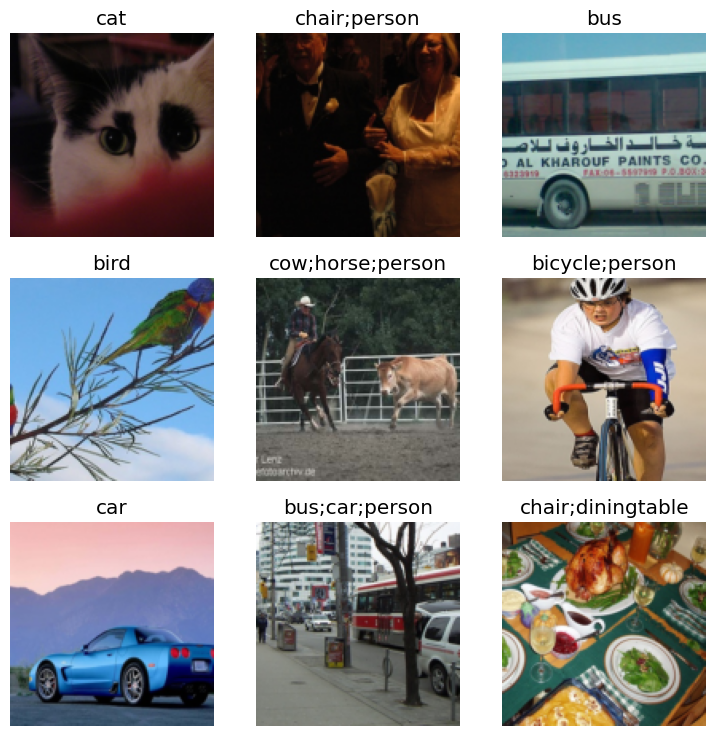

In [31]:
dls.show_batch()

In [32]:
learn = vision_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\rainf/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 11.2MB/s]


In [33]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [34]:
activs[0]

TensorImage([ 1.5225,  3.8984,  3.2941,  1.5397, -2.1577,  3.2552, -0.1479, -2.2983, -1.9516, -1.2612, -1.9616,  0.6236,  1.2071, -2.7324, -5.8788,  0.1195,  0.9998, -4.1764, -1.0799, -1.5927],
            grad_fn=<AliasBackward0>)

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [35]:
def accuracy(inp, targ, axis=-1):
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mea()

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()

In [ ]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

In [38]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09390716999769211,0.9433466196060181]

In [ ]:
preds, targets = learn.get_preds()

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [39]:
# Regression

In [40]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [41]:
path.ls().sorted()

(#50) [Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01.obj'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/02'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/02.obj'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/03'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/03.obj'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/04'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/04.obj'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/05'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/05.obj')...]

In [46]:
(path/'01').ls().sorted()

(#1000) [Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/depth.cal'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [48]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('C:/Users/rainf/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [53]:
im = PILImage.create(img_files[0])
im.shape

((480, 640), <PIL.Image.Image image mode=RGB size=160x120>)

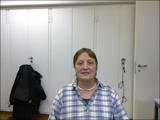

In [54]:
im.to_thumb(160)

In [55]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [56]:
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [61]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)),
)

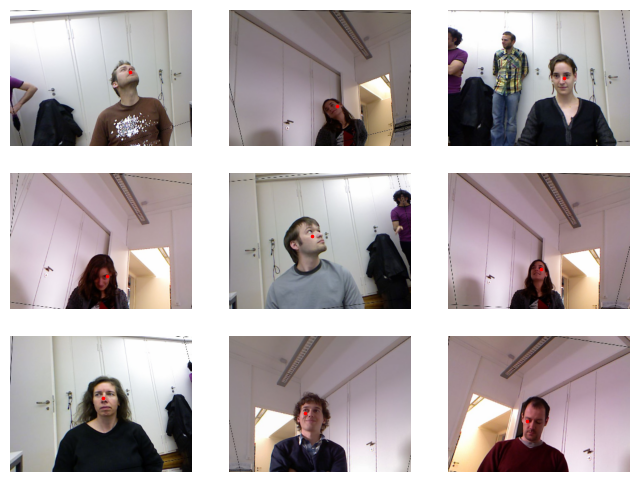

In [62]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [63]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [65]:
yb[0]

TensorPoint([[ 0.0984, -0.0018]], device='cuda:0')

In [67]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [68]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x) * (hi-lo) + lo

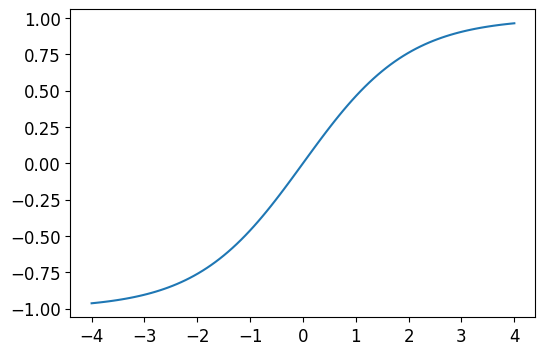

In [70]:
plot_function(partial(sigmoid_range, lo=-1,hi=1), min=-4, max=4)

In [71]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0063095735386013985)

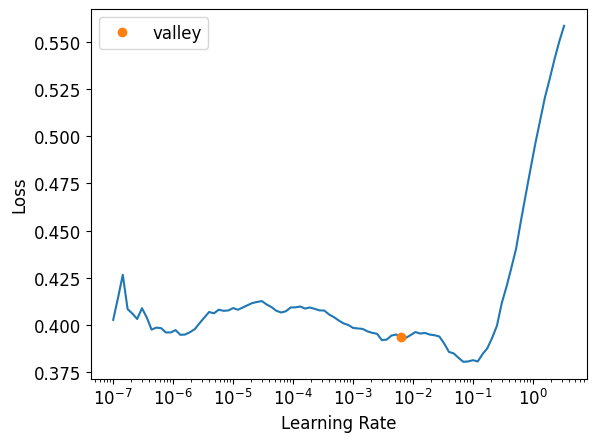

In [72]:
learn.lr_find()

In [73]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048732,0.045348,03:23


epoch,train_loss,valid_loss,time
0,0.007523,0.001443,02:16
1,0.003203,0.000352,02:18
2,0.001547,0.000130,02:15


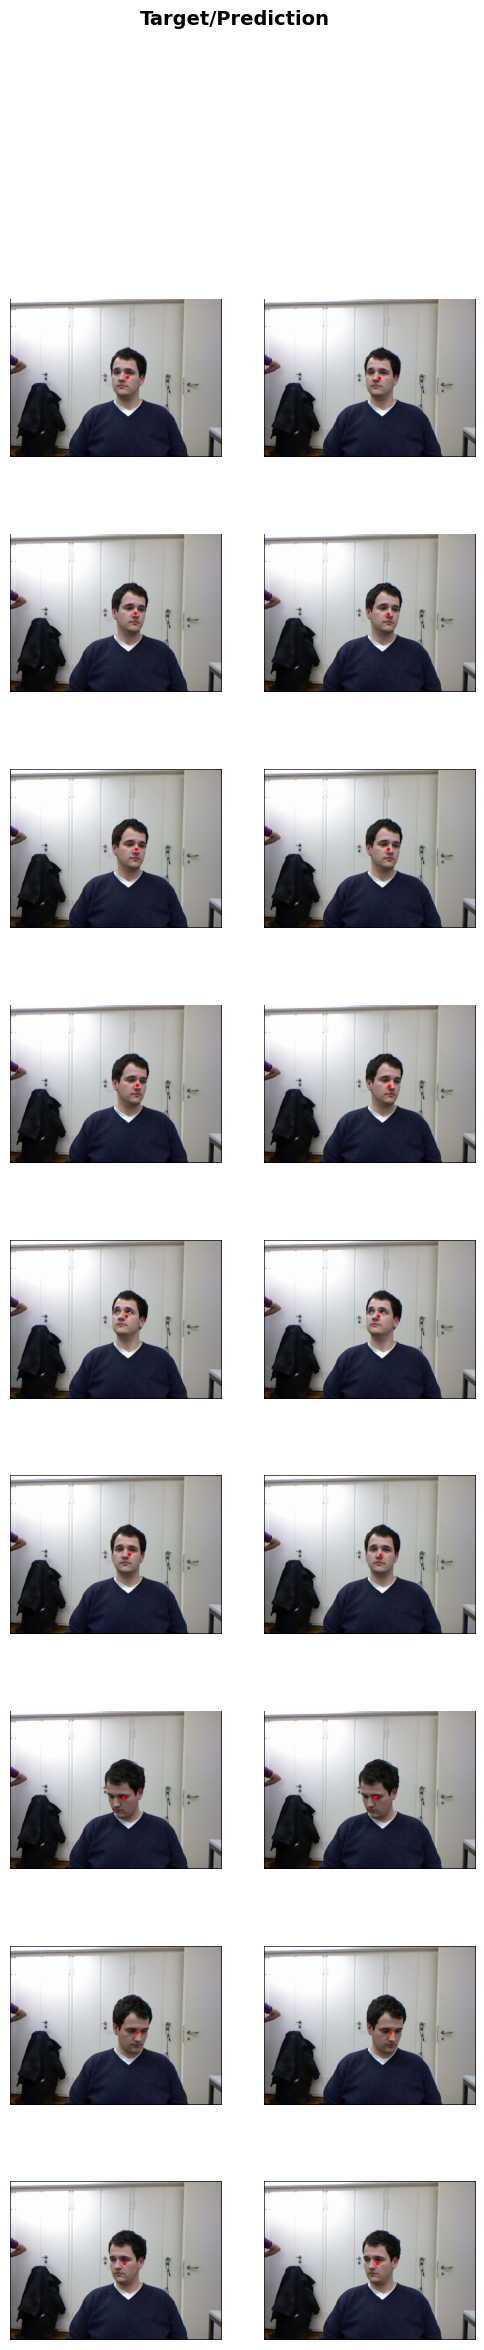

In [74]:
learn.show_results()